# Generación de paleta de colores a partir de imágenes con técnicas de machine learning no supervisado

In [1]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

## Funciones
En esta sección se definen las funciones a utilizar.

In [3]:

def get_relative_paths(folder_path):
    """
    Obtiene los paths relativos de todas las imágenes en la carpeta folder_path

    Parametros:
    folder_path : str
        path de la carpeta que contiene las imágenes
    
    Returns:
    files : list
        lista con los paths relativos de todas las imágenes en la carpeta folder_path
    """
    files = []
    for root, _, filenames in os.walk(folder_path):
        for filename in filenames:
            files.append(os.path.join(root, filename))
    return files



## Data
Para este proyecto se tomaron 156 imágenes en formato `.jpg` del repositorio [Wikiart](https://www.kaggle.com/datasets/steubk/wikiart) de Kaggle. Las imágenes se encuentran en la carpeta `Data` y se dividen en carpetas por estilo artístico.

Número de imágenes en la carpeta: 156


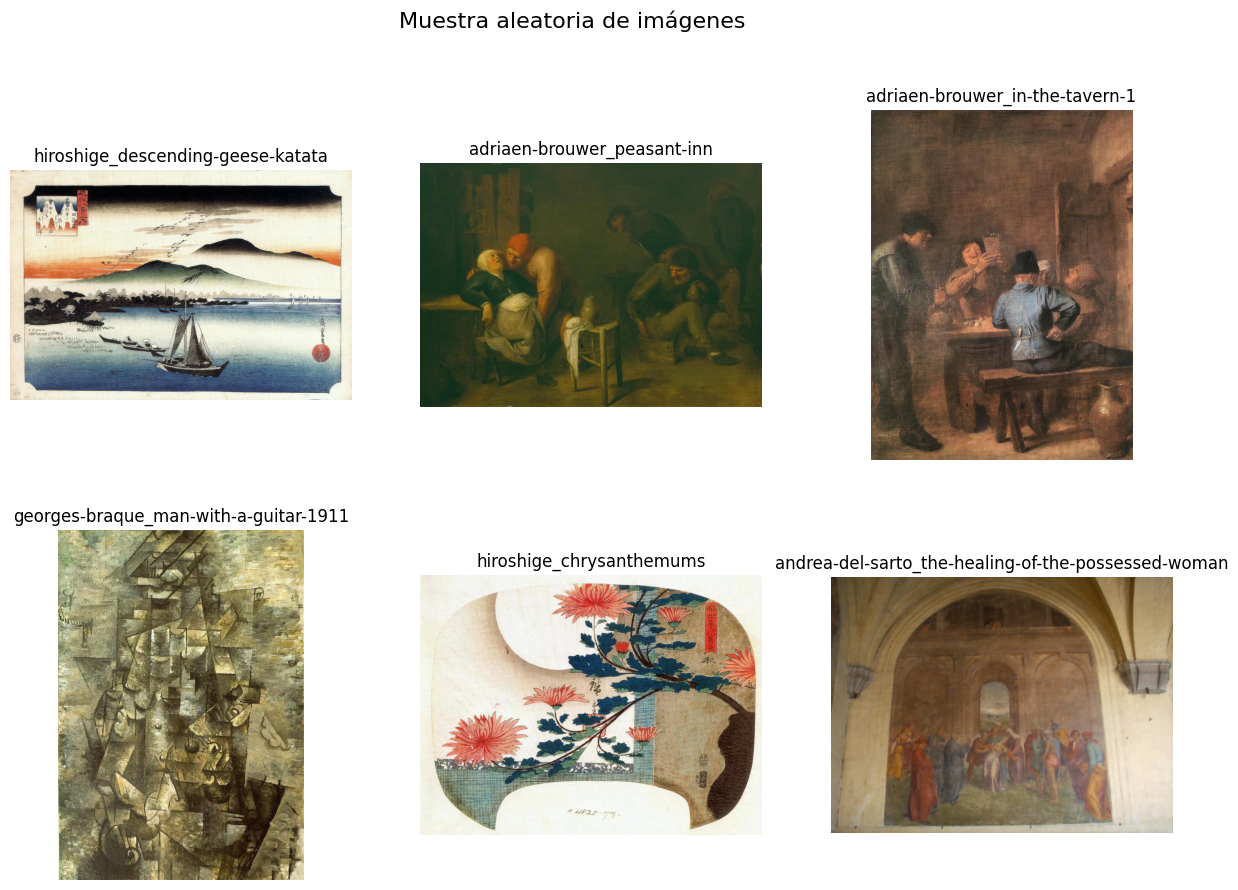

In [29]:
# Listar archivos
image_path = "./Data/"
images_list = get_relative_paths(image_path)
print(f"Número de imágenes en la carpeta: {len(images_list)}")

# 6 imágenes aleatorias
np.random.seed(47)
np.random.shuffle(images_list)

fig, ax = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle("Muestra aleatoria de imágenes", fontsize=16)
for i in range(6):
    img = cv2.imread(images_list[i])
    ax[i//3, i%3].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax[i//3, i%3].title.set_text(images_list[i].split("\\")[-1].replace(".jpg", ""))
    ax[i//3, i%3].axis('off')


## Modelado

### Preprocesamiento
Para el preprocesamiento de las imágenes se utilizó la librería `PIL` para redimensionar las imágenes a un tamaño de 128x128 píxeles y convertirlas a RGB. Posteriormente, se "aplanan" las imágenes para convertirlas en un arreglo donde cada elemento está dado por pixel x canales de color, finalmente se normalizaron los valores de los píxeles dividiendo entre 255 para tener rangos de 0 a 1.

Ejemplo imagen preprocesada:
[[0.91372549 0.82352941 0.69019608]
 [0.90588235 0.81568627 0.68235294]
 [0.90980392 0.81960784 0.68627451]
 ...
 [0.90980392 0.85882353 0.79215686]
 [0.89019608 0.83137255 0.75294118]
 [0.8745098  0.81176471 0.7254902 ]]


(-0.5, 499.5, 499.5, -0.5)

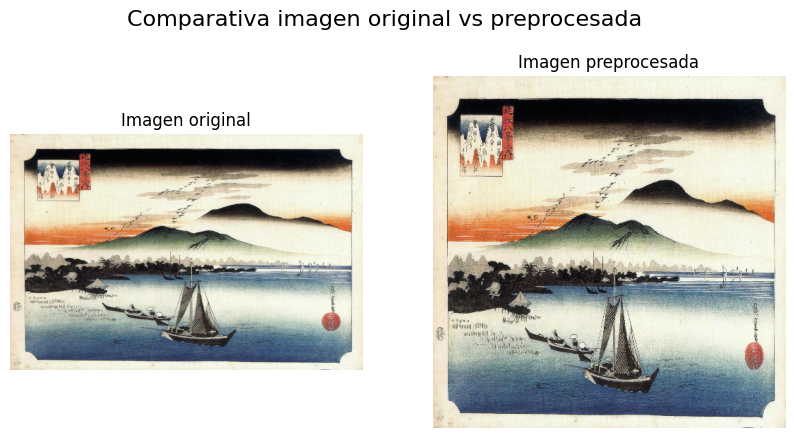

In [55]:
dimension_resize = 500

def preprocesar_imagen(image_path,dimension_resize=dimension_resize):
    # cargar imagen
    image = cv2.imread(image_path)
    # Convertir a RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # Redimensionar
    image = cv2.resize(image, (dimension_resize, dimension_resize))
    # Flatten the image
    image = image.reshape((-1, 3))
    # normalize
    image = image / 255.0
    return image

print("Ejemplo imagen preprocesada:")
print(preprocesar_imagen(images_list[0]))

# Comparativa imagen original vs preprocesada
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle("Comparativa imagen original vs preprocesada", fontsize=16)
img = cv2.imread(images_list[0])
ax[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax[0].title.set_text("Imagen original")
ax[0].axis('off')
# agregar un reshape dado que la imagen preprocesada es un vector
img = preprocesar_imagen(images_list[0]).reshape((dimension_resize, dimension_resize, 3))
ax[1].imshow(img)
ax[1].title.set_text("Imagen preprocesada")
ax[1].axis('off')



### Modelos
Dado el contexto del problema, se opta por usar modelos de clustering no supervisado.

Aquí un resumen de algunas ventajas y desventajas de los modelos de clustering más comunes:

| Modelo de clustering                     | Ventajas                                                                                                                                              | Desventajas                                                                                                                                  |
|:-----------------------------------------|:------------------------------------------------------------------------------------------------------------------------------------------------------|:---------------------------------------------------------------------------------------------------------------------------------------------|
| K-Means                                  | - Simple y eficiente computacionalmente. <br> - Fácil de implementar e interpretar.                                                                   | - Requiere especificar el número de grupos (k) de antemano. <br> - Sensible a la inicialización y puede converger a óptimos locales.             |
|K-Medoids|	- Robusto a outliers. <br> - No se basa en el cálculo de la media (sino escoge prototipos), lo que lo hace útil para datos no euclidianos.|	- Más lento que K-means debido a la necesidad de calcular todas las distancias entre puntos. <br> - Sensible a la elección de los medoids iniciales.|
| Mean Shift                               | - No requiere especificar el número de grupos. <br> - Puede capturar grupos con formas irregulares.                                                   | - Intensivo computacionalmente, especialmente para conjuntos de datos grandes. <br> - Puede converger a soluciones subóptimas.               |
| DBSCAN (Agrupamiento Basado en Densidad) | - Detecta automáticamente el número de grupos. <br> - Robusto al ruido y valores atípicos.                                                            | - Requiere ajustar dos parámetros. <br> - Puede no funcionar bien con grupos de densidades variables.                                        |
| Agrupamiento Jerárquico Aglomerativo     | - Produce una jerarquía de grupos que pueden visualizarse. <br> - No requiere especificar el número de grupos.                                        | - Puede ser computacionalmente costoso. <br> - No es adecuado para conjuntos de datos muy grandes.                                           |
| Modelos de Mezclas Gaussianas (GMM)      | - Enfoque probabilístico que puede capturar grupos superpuestos. <br> - Puede estimar la incertidumbre en las asignaciones de grupos.                 | - Demanda computacionalmente. <br> - Sensible a la inicialización y puede converger a óptimos locales.                                       |
| Mapas Auto-Organizativos (SOM)           | - Produce una representación de baja dimensión de datos de alta dimensión. <br> - Puede preservar las propiedades topológicas del espacio de entrada. | - Requiere ajustar cuidadosamente los parámetros. <br> - Intensivo computacionalmente durante el entrenamiento.                              |
| Agrupamiento Fuzzy C-Means               | - Permite el agrupamiento suave, donde los puntos de datos pueden pertenecer a múltiples grupos con diferentes grados de membresía.                   | - Requiere especificar el número de grupos y un parámetro de difuminación. <br> - Más costoso computacionalmente que K-means.                |



Descarte de modelos:

- **K-Medoids**: Es más lento K-means dado que calcula todas las distancias entre puntos. Al estar basado en prototipos (colores que están realmente en la imagen) y las imágenes tener tanta variedad de colores crearía paletas no muy representativas.
- **Mean Shift**: Intensivo computacionalmente, especialmente para conjuntos de datos grandes(como las imágenes sin resize), al no poder especificar el número de grupos, tendríamos que filtrar entre los grupos con mayores pixeles agrupados.
- **DBSCAN**: Requiere ajustar dos parámetros. Puede no funcionar bien con grupos de densidades variables como en el caso de las imágenes de arte que pueden tener zonas con muchos colores y otras con pocos.
- **Agrupamiento Jerárquico Aglomerativo**: Puede ser computacionalmente costoso. No es adecuado para conjuntos de datos muy grandes.
- **Modelos de Mezclas Gaussianas (GMM)**: Intensivo computacionalmente. Sensible a la inicialización dada y puede quedar atrapado en óptimos locales.
- **Mapas Auto-Organizativos (SOM)**: Requiere un trabajo más itensivo al ajustar los parámetros. Intensivo computacionalmente durante el entrenamiento.

Modelos candidatos:

- **K-Means**: Al requerir número de grupos (k) de antemano, lo hace adecuado para el problema dado que esperamos obtener entre 5 a 7 colores, además al basarse en medias, nos puede dar el color representante que agrupa a los demás en la paleta, finalmente es simple y eficiente computacionalmente.
- **Agrupamiento Fuzzy C-Means**: De manera simialar a k-means requiere especificar el número de grupos, además de un parámetro de difuminación, lo que lo hace más costoso computacionalmente que K-means.



### Métricas
Para evaluar los modelos de clustering se utilizaron las siguientes métricas:

* Inercia: Mide la cohesión dentro de los clusters y se calcula como la suma de las distancias cuadradas de cada punto al centroide de su cluster.

* Coeficiente de Silueta (Silhouette Score):Evalúa la cohesión intra-cluster y la separación inter-cluster.Un valor de silueta cercano a +1 indica que los puntos están bien agrupados, mientras que un valor cercano a -1 indica que los puntos podrían estar mejor asignados a clusters diferentes.

In [56]:
# Parámetros KMeans
kmeans_params = {
    'n_clusters': 7,
    'init': 'k-means++',  
    'max_iter': 300,       
    'random_state': 100     
}

modelo_kmeans = KMeans(**kmeans_params)



